In [ ]:
!unzip archive.zip

Archive:  archive.zip
  inflating: PlantVillage/Tomato_Early_blight/0012b9d2-2130-4a06-a834-b1f3af34f57e___RS_Erly.B 8389.JPG  
  inflating: PlantVillage/Tomato_Early_blight/0034a551-9512-44e5-ba6c-827f85ecc688___RS_Erly.B 9432.JPG  
  inflating: PlantVillage/Tomato_Early_blight/004cbe60-8ff9-4965-92df-e86694d5e9ba___RS_Erly.B 8253.JPG  
  inflating: PlantVillage/Tomato_Early_blight/00c5c908-fc25-4710-a109-db143da23112___RS_Erly.B 7778.JPG  
  inflating: PlantVillage/Tomato_Early_blight/00e7c4b2-3005-4558-9cfa-235e356cb7a8___RS_Erly.B 7844.JPG  
  inflating: PlantVillage/Tomato_Early_blight/0114f7b3-7f56-4bef-aa47-7a82da142d4b___RS_Erly.B 7437.JPG  
  inflating: PlantVillage/Tomato_Early_blight/011aa278-a39e-40b0-b6e4-2e2f835889f0___RS_Erly.B 8251.JPG  
  inflating: PlantVillage/Tomato_Early_blight/01861c93-ea8b-4820-aaa8-cc6003b3e75b___RS_Erly.B 7855.JPG  
  inflating: PlantVillage/Tomato_Early_blight/01f87f04-ff38-4aba-b7d1-587aa06e5282___RS_Erly.B 7851.JPG  
  inflating: PlantVillag

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 25

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4500 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']

In [ ]:
len(dataset)

141

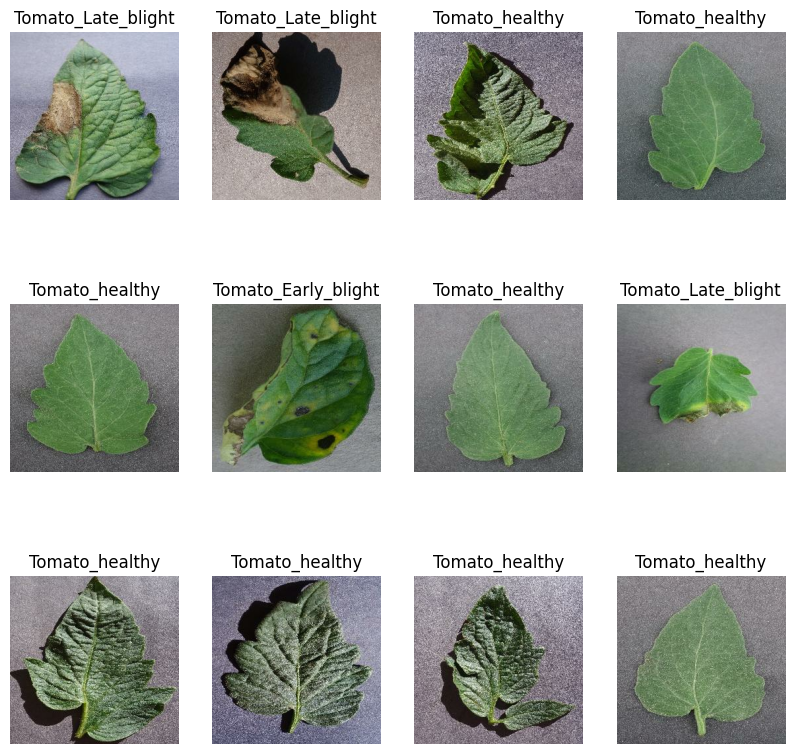

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
     ax = plt.subplot(3, 4, i+1)
     plt.imshow(image_batch[i].numpy().astype("uint8"))
     plt.title(class_names[label_batch[i]])
     plt.axis("off")

In [ ]:
train_size = 0.8
len(dataset)*train_size

112.80000000000001

In [ ]:
train_ds = dataset.take(112)
len(train_ds)

112

In [ ]:
test_ds = dataset.skip(112)
len(test_ds)

29

In [ ]:
val_size = 0.1
len(dataset)*val_size

14.100000000000001

In [ ]:
val_ds = test_ds.take(14)
len(val_ds)

14

In [ ]:
test_ds = test_ds.skip(14)
len(test_ds)

15

In [ ]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  assert (train_split + test_split + val_split) == 1

  ds_size = len(ds)
  
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

112

In [ ]:
len(test_ds)

15

In [ ]:
len(val_ds)

14

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25
)

Epoch 1/25
112/112 [==============================] - 539s 5s/step - loss: 0.8737 - accuracy: 0.5459 - val_loss: 0.5638 - val_accuracy: 0.7634
Epoch 2/25
112/112 [==============================] - 518s 5s/step - loss: 0.4028 - accuracy: 0.8354 - val_loss: 0.3221 - val_accuracy: 0.8527
Epoch 3/25
112/112 [==============================] - 528s 5s/step - loss: 0.3490 - accuracy: 0.8586 - val_loss: 0.4216 - val_accuracy: 0.8147
Epoch 4/25
112/112 [==============================] - 524s 5s/step - loss: 0.2945 - accuracy: 0.8819 - val_loss: 0.4938 - val_accuracy: 0.8214
Epoch 5/25
112/112 [==============================] - 520s 5s/step - loss: 0.2901 - accuracy: 0.8746 - val_loss: 0.6179 - val_accuracy: 0.8058
Epoch 6/25
112/112 [==============================] - 520s 5s/step - loss: 0.2574 - accuracy: 0.8933 - val_loss: 0.4395 - val_accuracy: 0.8504
Epoch 7/25
112/112 [==============================] - 558s 5s/step - loss: 0.2654 - accuracy: 0.8880 - val_loss: 0.1941 - val_accuracy: 0.8996

In [ ]:
score = model.evaluate(test_ds)

15/15 [==============================] - 28s 1s/step - loss: 0.1171 - accuracy: 0.9521


In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict as displayed ")
    plt.imshow(first_image)
    print("Actual label :",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label :",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual : {actual_class},\n Predicted : {predicted_class}.\n Confidence : {confidence}%")
        
        plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

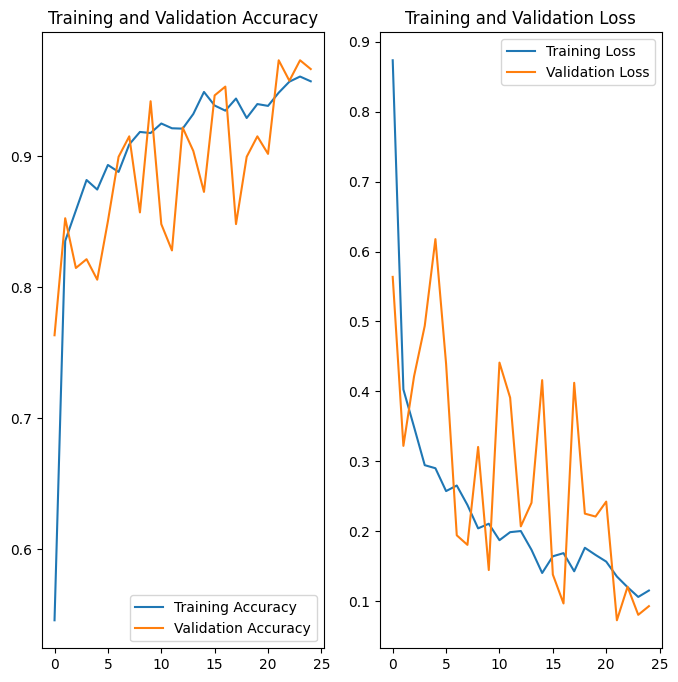

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
np.argmax([9.9999964e-01,3.9333537e-07,1.1586251e-18])

0

first image to predict
actual label: Tomato_Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Tomato_Late_blight


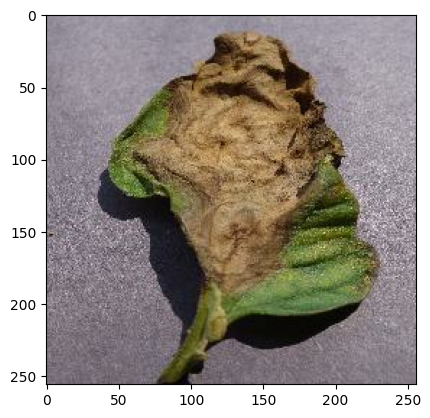

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

  first_image = images_batch[2].numpy().astype('uint8')
  first_label = labels_batch[2].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])

  batch_prediction = model.predict(images_batch)
  print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [ ]:
model.save('name.h5')